In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from os import listdir
from sklearn import preprocessing
from matplotlib.image import imread
import cv2
from tqdm.notebook import trange, tqdm
import time
from tensorflow.keras.models import Model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from tqdm.notebook import tqdm
from sklearn.metrics.cluster import adjusted_rand_score
import os


In [3]:
def pca_tsne(mat_inp, df_input, col_labels, nb_labels, colors_list, name="" ,niter=3000, ppxt=30, seuil=95):
    
    if scipy.sparse.issparse(mat_inp):
        mat = pd.DataFrame(mat_inp.todense())
    else: mat = pd.DataFrame(mat_inp)

    dfpca, dims = fct_pca(mat)

    for i in range(0, len(dims), 1):
        if sum(dims[0:i]) >= seuil:
            dfpca = dfpca.iloc[:, 0:i]
            print(i, 'dimensions après pca')
            break

    tsne = manifold.TSNE(n_components=2,
                         perplexity=ppxt,
                         n_iter=niter,
                         init='random',
                         learning_rate=100,
                         random_state=42)

    X_tsne = tsne.fit_transform(dfpca)

    cls = cluster.KMeans(n_clusters=nb_labels, n_init=300, random_state=42)
    cls.fit(X_tsne)

    df_transdata = pd.DataFrame(X_tsne, index=df_input.index)
    df_transdata = df_transdata.merge(df_input[col_labels],
                                      left_index=True,
                                      right_index=True)

    df_transdata['labels_pred'] = cls.labels_

    fig, ax = plt.subplots(figsize=(8, 8))

    sns.scatterplot(
        x=df_transdata[0],
        y=df_transdata[1],
        hue=df_transdata["labels_pred"],
        palette=colors_list,
        legend="brief",
        edgecolor='k',
        alpha=0.6)

    plt.title("Visualisation des clusters avec t-SNE", fontsize=15)
    plt.savefig(name+"_TSNE.png", bbox_inches='tight')

    plt.show()
    plt.close('all')
    ari=np.round(
            metrics.adjusted_rand_score(df_transdata.labels,
                                        df_transdata.labels_pred), 4)
    print("ari:",ari)
    return(ari, df_transdata)

def fct_pca(matrix):

    x_prenorm = matrix

    # Normalisation
    scaler = RobustScaler()
    x = scaler.fit_transform(x_prenorm)
 #   x = np.log2(x+1)

    data_norm = pd.DataFrame(x)
    pca_test = PCA()
    principalComponents_test = pca_test.fit_transform(x)  #ndarray

    principal_test_Df = pd.DataFrame(data=principalComponents_test)
 
    #print(pca_test.explained_variance_ratio_ * 100)

    return (principal_test_Df, pca_test.explained_variance_ratio_ * 100)

from random import randint
def colorlist(n):
    color = []

    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    return(color)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [65]:
path = "Flipkart/Images/"

path_out='ImageAnalysis_Figures/'
if not os.path.exists(path_out):
    os.makedirs(path_out)

In [7]:
table_id=pd.read_csv('table_id.csv')
table_id['path']=table_id['uniq_id'].astype(str)+'.jpg'
le = preprocessing.LabelEncoder()
table_id["label"] = le.fit_transform(table_id["labels"])

list_photos=table_id['path']

In [8]:
# Chargement du modèle + sélection des couches
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

2023-08-11 17:28:43.962939: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/camille/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-08-11 17:28:43.962959: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-11 17:28:43.963008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (camille-NL40-50CU): /proc/driver/nvidia/version does not exist
2023-08-11 17:28:43.963297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropria

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 134,260,544
Trainable params: 134,260,544
Non-trainable params: 0
_________________________________________________________________
None


## Préprocessing des images 
Pas de passage en nuances de gris - atténuation du bruit et redimensionnement

In [29]:
vgg_keypoints = []
target_size = (224, 224)
temps1=time.time()

for elem in tqdm(range(len(list_photos))):
  
    im = cv2.imread(path + list_photos[elem])  # image en couleur
    im = cv2.resize(im, target_size, interpolation=cv2.INTER_LINEAR)
    
#     clahe = cv2.createCLAHE(clipLimit=40, tileGridSize=(5, 5))
#     im = clahe.apply(im)
#    im=remove_white_bg(im) 

    image = cv2.fastNlMeansDenoising(im, None)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    features = model.predict(image)
    
    vgg_keypoints.append(features)

vgg_keypoints_by_img = np.asarray(vgg_keypoints)
vgg_keypoints_all    = np.concatenate(vgg_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs VGG : ", vgg_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement VGG descriptor : ", "%15.2f" % duration1, "secondes")

  0%|          | 0/1050 [00:00<?, ?it/s]


Nombre de descripteurs VGG :  (1050, 4096)
temps de traitement VGG descriptor :           356.40 secondes


In [47]:
#ARI sans PCA
from sklearn.cluster import KMeans

km_vgg = KMeans(n_clusters=7)
km_vgg.fit(vgg_keypoints_all)

ari = adjusted_rand_score(table_id.label, km_vgg.labels_)
print('ARI :',ari)

ARI : 0.43713410366909067


4000 dimensions -> pour un traitement efficace, une PCA est nécessaire

In [46]:
# ARI avec PCA
from sklearn import manifold, decomposition

print("Dimensions avant réduction PCA : ", vgg_keypoints_all.shape)
pca_vgg = decomposition.PCA(n_components=0.99)
feat_pca_vgg = pca_vgg.fit_transform(vgg_keypoints_all)
print("Dimensions après réduction PCA : ", feat_pca_vgg.shape)

km_vgg_pca = KMeans(n_clusters=7)
km_vgg_pca.fit(feat_pca_vgg)

ari_pca = adjusted_rand_score(table_id.label, km_vgg_pca.labels_)
print()
print('ARI pca :',ari_pca)

Dimensions avant réduction PCA :  (1050, 4096)
Dimensions après réduction PCA :  (1050, 795)
ARI pca : 0.42223684209766904


In [35]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=3000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca_vgg)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = table_id['label']
df_tsne["cluster"] = km_vgg.labels_

/home/camille/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


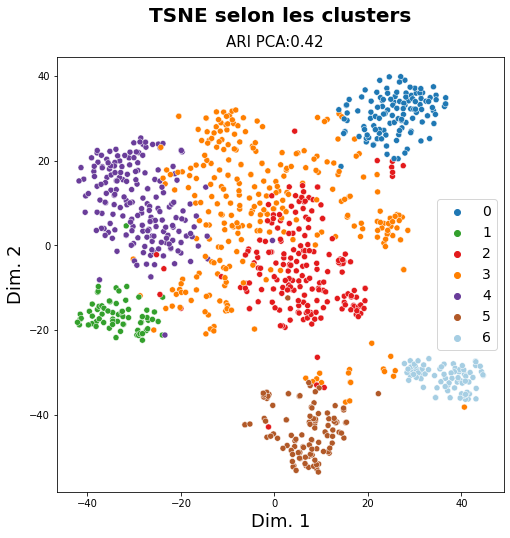

ARI :  0.43713410366909067


In [71]:
colorlist=['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#b15928', '#a6cee3']

plt.figure(figsize=(8, 8))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue="cluster",
                palette=colorlist,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les clusters', pad=35,fontsize=20, fontweight='bold')
plt.text(0, 47, "ARI PCA:"+str(np.round(ari_pca, 2)), ha='center', fontsize=15) 
plt.xlabel('Dim. 1', fontsize=18)
plt.ylabel('Dim. 2', fontsize=18)
plt. grid(False)
plt.legend(prop={'size': 14})
plt.savefig(path_out+"CNN_clusters.png",bbox_inches='tight')

plt.show()

labels = table_id["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, km_vgg.labels_))

In [76]:
df_tsne['decoded class']=le.inverse_transform(df_tsne['class'])

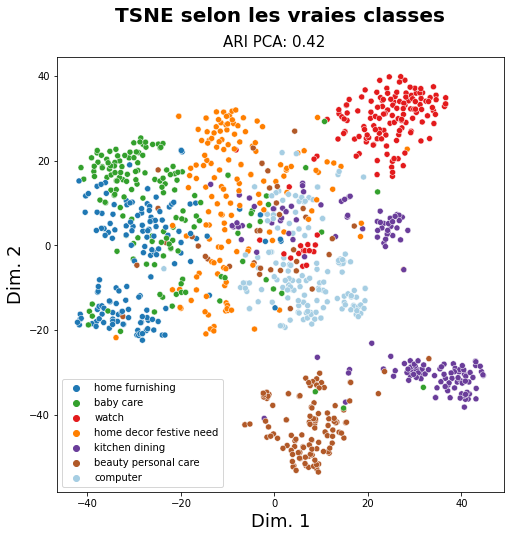

In [78]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue='decoded class',
                 palette=colorlist,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les vraies classes', pad=35,fontsize=20, fontweight='bold')
plt.text(0, 47, "ARI PCA: "+str(np.round(ari_pca, 2)), ha='center', fontsize=15) 
plt.xlabel('Dim. 1', fontsize=18)
plt.ylabel('Dim. 2', fontsize=18)
plt. grid(False)
plt.legend(prop={'size': 10})
plt.savefig(path_out+"CNN_vraiesclasses.png",bbox_inches='tight')

plt.show()

labels = table_id["label"]

In [80]:
table_id["label"]

0       4
1       0
2       0
3       4
4       4
       ..
1045    0
1046    0
1047    0
1048    0
1049    0
Name: label, Length: 1050, dtype: int64

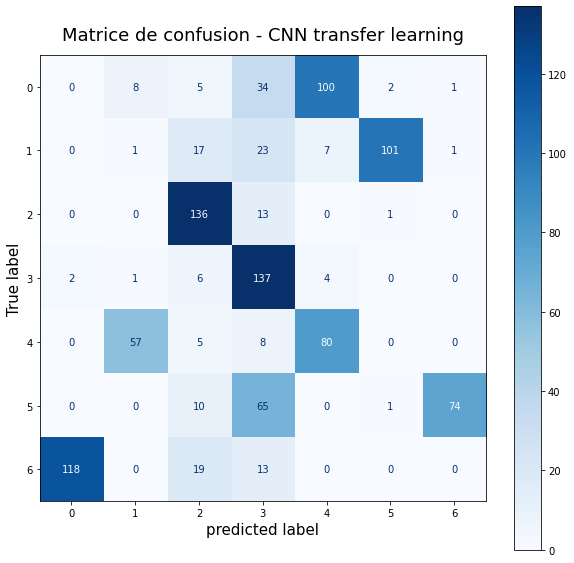

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(table_id["label"].values, km_vgg.labels_)

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm).plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Matrice de confusion - CNN transfer learning", size=18, pad=15)
plt.ylabel("True label",size=15)
plt.xlabel("predicted label",size=15)
plt.savefig(path_out+"CMatrix_CNN.png", bbox_inches="tight")
plt.grid(False)
plt.show()